In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from Bio.PDB import PDBParser, Superimposer
from tqdm.auto import tqdm

In [2]:
def compute_average_plddt(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_file)

    b_factors = []

    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    b_factors.append(atom.bfactor)

    if b_factors:
        average_bfactor = sum(b_factors) / len(b_factors)
        return average_bfactor
    else:
        return None

def get_ca_atoms(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    ca_atoms.append(residue['CA'])
    return ca_atoms

def compute_rmsd(file1, file2):
    ca_atoms1 = get_ca_atoms(file1)
    ca_atoms2 = get_ca_atoms(file2)

    if len(ca_atoms1) != len(ca_atoms2):
        raise ValueError("The number of C-alpha atoms in the two structures are different.")

    # Extract the coordinates
    coords1 = np.array([atom.get_coord() for atom in ca_atoms1])
    coords2 = np.array([atom.get_coord() for atom in ca_atoms2])

    # Superimpose the structures
    super_imposer = Superimposer()
    super_imposer.set_atoms(ca_atoms1, ca_atoms2)
    super_imposer.apply(ca_atoms2)
    
    # Calculate RMSD
    rmsd = super_imposer.rms
    return rmsd

In [5]:
# folder = Path("/nfs/homedirs/hetzell/code/protein_design/example_outputs/23Aug24_frameflow_design/openfold_monomer/predictions")
# folder = Path("/nfs/homedirs/hetzell/code/protein_design/example_outputs/03Sep24_dna_design_0.4/openfold_monomer/predictions")
folder = Path("/nfs/homedirs/hetzell/code/protein_design/project_folder/validation/07Nov24_rfdiff_dataset/openfold_homomer/predictions")
pdb_dict = {}

for pdb_file in tqdm(folder.iterdir()):
    # check that pdb_file is pdb file
    if not pdb_file.is_file() or not pdb_file.suffix == ".pdb":
        continue
    # if "400" in pdb_file.stem: 
    #     continue
    # # if length < 420: 
    #     continue
    
    length = len(list(get_ca_atoms(pdb_file)))
    # template = folder.parent.parent / "pdbs" / ('_'.join(pdb_file.stem.split("_")[:2]) + ".pdb")
    template = folder.parent.parent / "pdbs" / ('_'.join(pdb_file.stem.split("_")[:-8]) + ".pdb")
    assert template.is_file(), f"Template file {template} not found"
    
    average_plddt = compute_average_plddt(pdb_file)
    rmsd = compute_rmsd(template, pdb_file)
    reference = template.stem
    pdb_dict[pdb_file.stem] = [average_plddt, rmsd, length, reference]
    # print(f"The average pLDDT score is: {average_plddt}")

77it [00:22,  3.47it/s]


In [9]:
df = pd.DataFrame.from_dict(pdb_dict, orient="index", columns=["average_plddt", "rmsd", "length", "reference"])

# sort df according to average_plddt
# df = df.sort_values(by="rmsd", ascending=True)
df = df.sort_values(by="average_plddt", ascending=False)

In [10]:
df["length"].value_counts()

180    76
Name: length, dtype: int64

<Axes: >

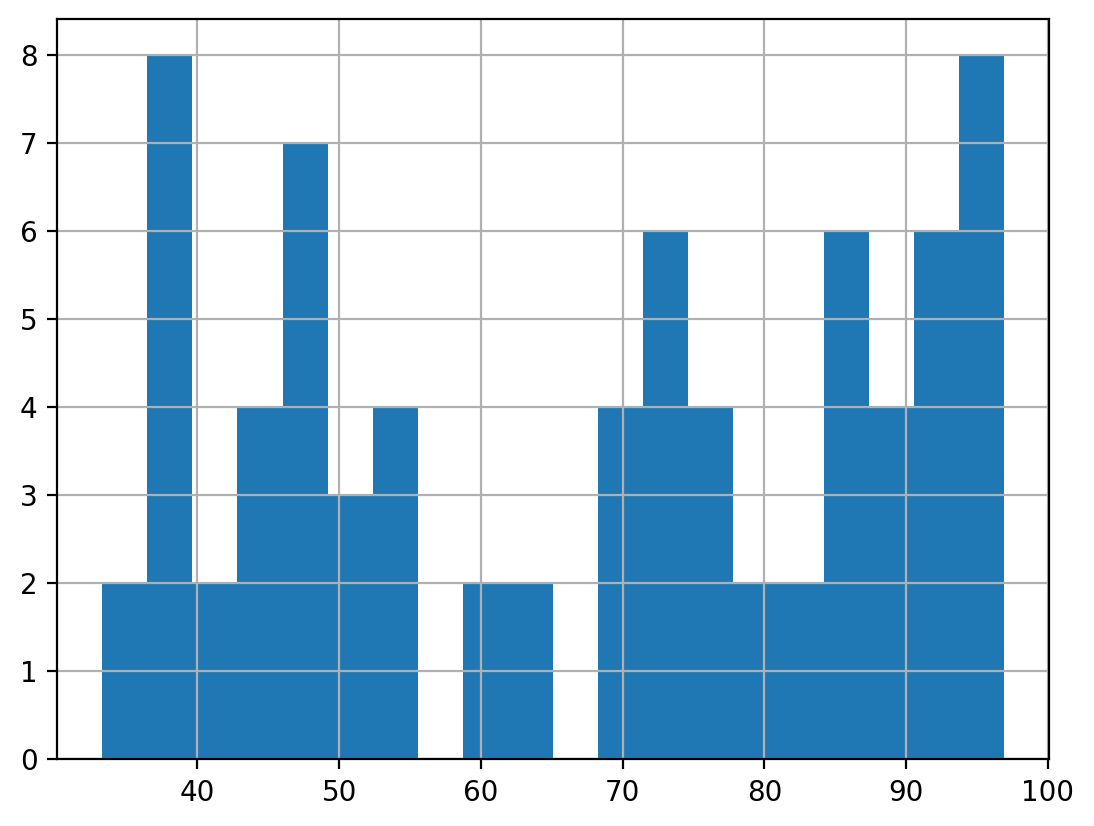

In [13]:
df["average_plddt"].hist(bins=20)

In [9]:
lens = [480]

df[df["length"].isin(lens)].groupby("reference")["average_plddt"].max().sort_values(ascending=False)

reference
length_480_sample_39    77.554702
length_480_sample_25    67.548847
length_480_sample_41    58.329338
length_480_sample_13    57.852393
length_480_sample_44    57.645445
length_480_sample_33    55.674430
length_480_sample_22    55.481456
length_480_sample_10    54.576375
length_480_sample_3     54.146824
length_480_sample_15    54.127025
length_480_sample_28    53.619287
length_480_sample_46    52.724585
length_480_sample_35    51.937669
length_480_sample_14    51.730168
length_480_sample_24    51.573514
length_480_sample_45    50.966351
length_480_sample_30    50.707692
length_480_sample_31    50.571552
length_480_sample_4     47.526795
length_480_sample_7     47.333486
length_480_sample_26    46.889675
length_480_sample_32    45.756298
length_480_sample_20    45.465875
length_480_sample_48    45.444328
length_480_sample_27    44.882847
length_480_sample_2     44.523571
length_480_sample_12    44.482784
length_480_sample_8     44.429616
length_480_sample_21    43.707228
leng

In [11]:
df.loc[df.groupby("reference")["average_plddt"].idxmax()].sort_values(by="rmsd", ascending=True)[df["average_plddt"] > 55]

/tmp/ipykernel_1626980/1236880629.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.loc[df.groupby("reference")["average_plddt"].idxmax()].sort_values(by="rmsd", ascending=True)[df["average_plddt"] > 55]


,average_plddt,rmsd,length,reference
length_480_sample_25_8__A-B-C-D-E-F-G-H_model_1_multimer_v3_relaxed,67.548847,4.792712,480,length_480_sample_25
length_480_sample_13_2__A-B-C-D-E-F-G-H_model_1_multimer_v3_unrelaxed,57.852393,15.296778,480,length_480_sample_13
length_480_sample_22_6__A-B-C-D-E-F-G-H_model_1_multimer_v3_relaxed,55.481456,17.847378,480,length_480_sample_22
length_480_sample_33_8__A-B-C-D-E-F-G-H_model_1_multimer_v3_relaxed,55.674430,20.986133,480,length_480_sample_33
length_480_sample_44_3__A-B-C-D-E-F-G-H_model_1_multimer_v3_unrelaxed,57.645445,21.190221,480,length_480_sample_44
length_480_sample_41_6__A-B-C-D-E-F-G-H_model_1_multimer_v3_unrelaxed,58.329338,25.610162,480,length_480_sample_41
length_480_sample_39_3__A-B-C-D-E-F-G-H_model_1_multimer_v3_relaxed,77.554702,27.242825,480,length_480_sample_39


In [12]:
files = (
    df.loc[df.groupby("reference")["average_plddt"].idxmax()]
    .sort_values(by="rmsd", ascending=True)[df["average_plddt"] > 55]
    .index
)

template = (
    lambda s: f"rsync -zaP fs:/nfs/homedirs/hetzell/code/protein_design/example_outputs/26Aug24_frameflow_design_symmetry/openfold_homomer/predictions/{s}.pdb ~/Downloads ;"
)

command = ""
for fn in files:
    command += template(fn)

/tmp/ipykernel_1626980/1018762650.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.loc[df.groupby("reference")["average_plddt"].idxmax()]


In [13]:
command

'rsync -zaP fs:/nfs/homedirs/hetzell/code/protein_design/example_outputs/26Aug24_frameflow_design_symmetry/openfold_homomer/predictions/length_480_sample_25_8__A-B-C-D-E-F-G-H_model_1_multimer_v3_relaxed.pdb ~/Downloads ;rsync -zaP fs:/nfs/homedirs/hetzell/code/protein_design/example_outputs/26Aug24_frameflow_design_symmetry/openfold_homomer/predictions/length_480_sample_13_2__A-B-C-D-E-F-G-H_model_1_multimer_v3_unrelaxed.pdb ~/Downloads ;rsync -zaP fs:/nfs/homedirs/hetzell/code/protein_design/example_outputs/26Aug24_frameflow_design_symmetry/openfold_homomer/predictions/length_480_sample_22_6__A-B-C-D-E-F-G-H_model_1_multimer_v3_relaxed.pdb ~/Downloads ;rsync -zaP fs:/nfs/homedirs/hetzell/code/protein_design/example_outputs/26Aug24_frameflow_design_symmetry/openfold_homomer/predictions/length_480_sample_33_8__A-B-C-D-E-F-G-H_model_1_multimer_v3_relaxed.pdb ~/Downloads ;rsync -zaP fs:/nfs/homedirs/hetzell/code/protein_design/example_outputs/26Aug24_frameflow_design_symmetry/openfold_ho

<Axes: xlabel='average_plddt', ylabel='rmsd'>

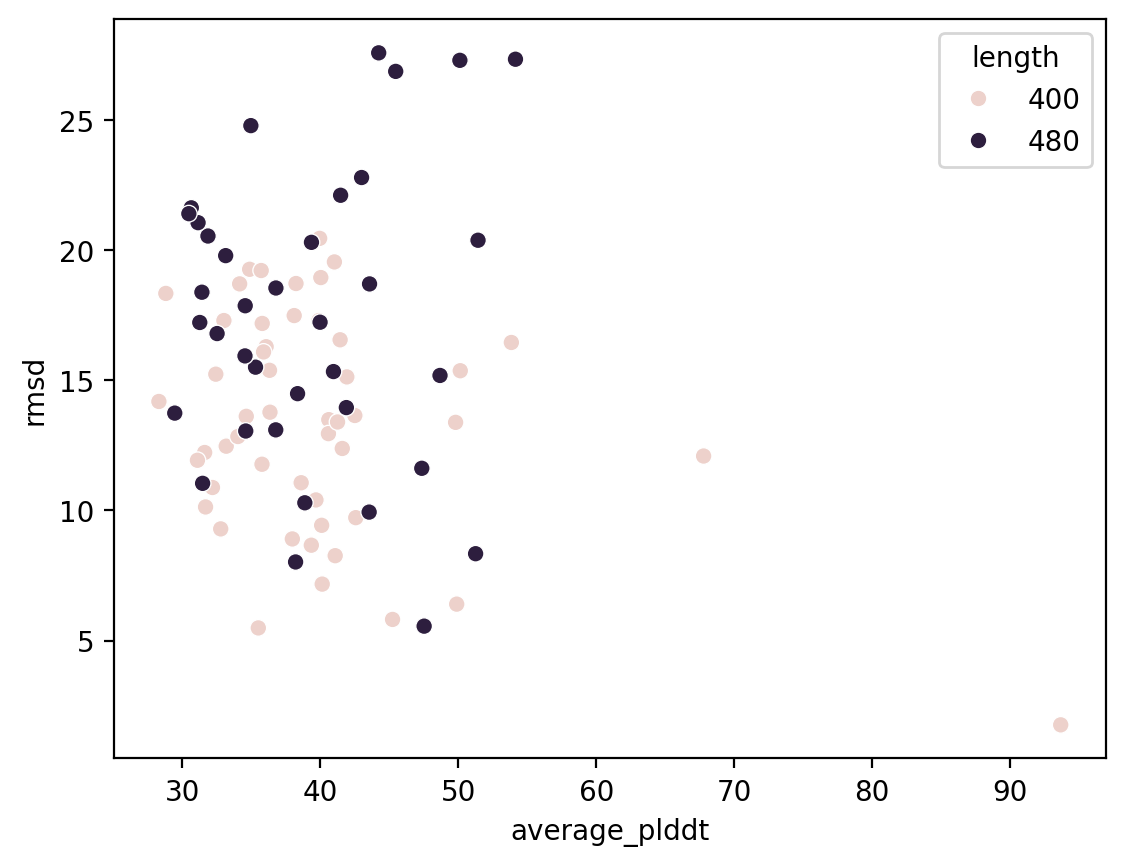

In [8]:
import seaborn as sns

sns.scatterplot(data=df.loc[df.groupby("reference")["rmsd"].idxmin()], x="average_plddt", y="rmsd", hue="length")

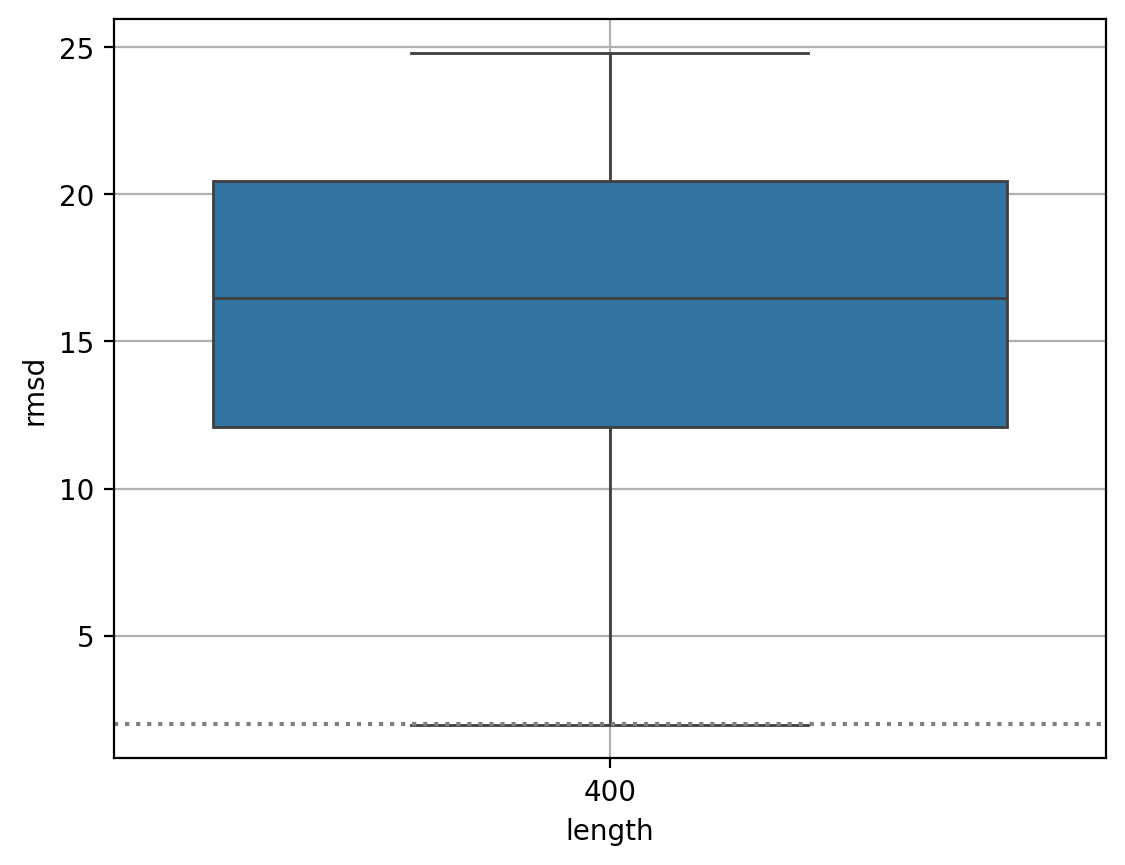

In [9]:
import matplotlib.pyplot as plt

sns.boxplot(data=df.loc[df.groupby("reference")["rmsd"].idxmin()], x="length", y="rmsd")
# add horizontal line for 2.0 A
plt.axhline(y=2.0, color='gray', linestyle=':')
# add grid 
plt.grid(":")

<Axes: xlabel='average_plddt', ylabel='rmsd'>

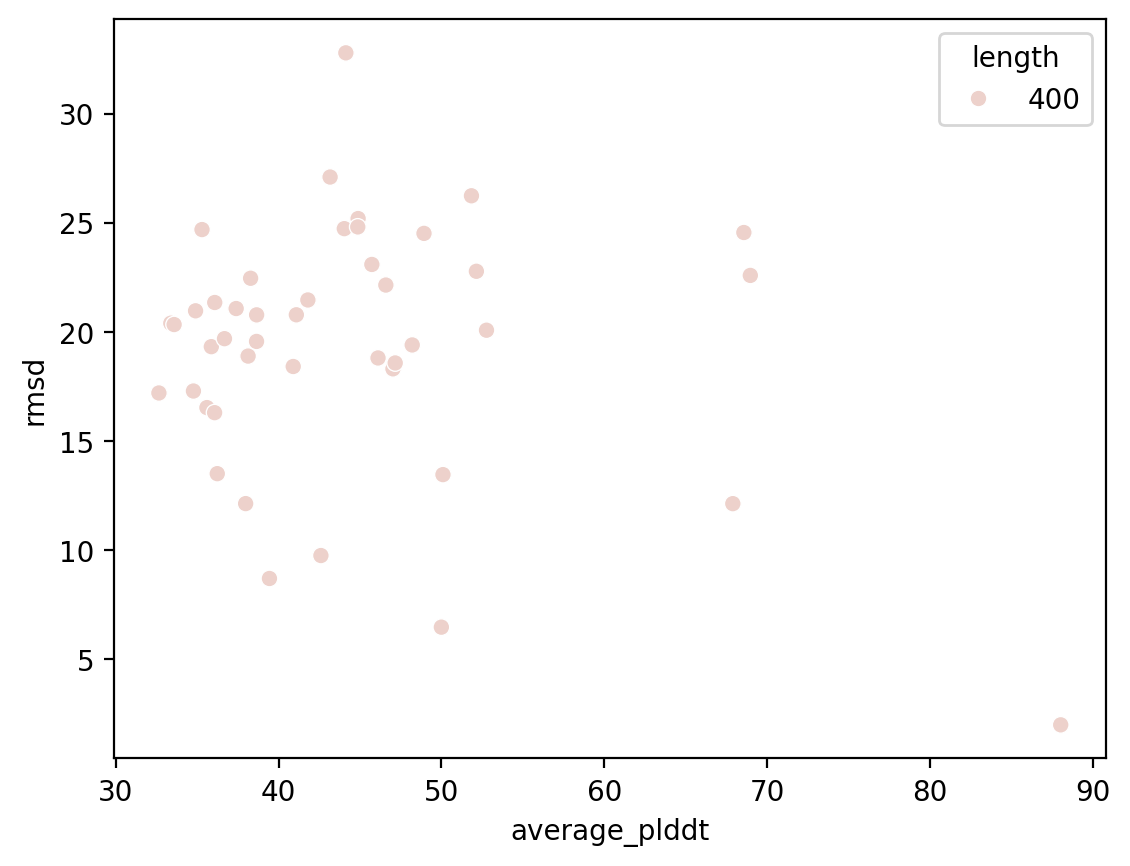

In [10]:
sns.scatterplot(data=df.loc[df.groupby("reference")["average_plddt"].idxmax()], x="average_plddt", y="rmsd", hue="length")

In [7]:
df.to_csv(f"{folder}/average_plddt.csv")